In [99]:
import pandas as pd
import numpy as np
import librosa

def load_audio(audio_path):
    return librosa.load(audio_path, sr=None)

df = pd.read_csv('Path_DF.csv')
slider_train = df[(df.Dataset == 'train') & (df.Machine_Type == 'slider')]

slider_train.head()

,Path,Machine_Type,Dataset,Status,Machine_ID,Sample_ID,nb_echantillon,freq_echantillonnage,audio
11969,Data/slider/train/normal_id_00_00000692.wav,slider,train,normal,0,692,160000,16000,[-0.01812744 -0.02529907 -0.02410889 ... -0.01...
11970,Data/slider/train/normal_id_06_00000093.wav,slider,train,normal,6,93,160000,16000,[ 0.00030518 -0.01733398 0.00076294 ... -0.01...
11971,Data/slider/train/normal_id_00_00000686.wav,slider,train,normal,0,686,160000,16000,[ 0.00491333 -0.00527954 -0.01107788 ... -0.01...
11972,Data/slider/train/normal_id_06_00000087.wav,slider,train,normal,6,87,160000,16000,[-0.0083313 -0.01031494 -0.01416016 ... 0.00...
11973,Data/slider/train/normal_id_02_00000058.wav,slider,train,normal,2,58,160000,16000,[0.00817871 0.01330566 0.012146 ... 0.005401...


## Cette fonction permet de faire une sélection de features MFEC sur un fichier audio 

In [100]:
def file_load_stream(wav_name, mono=False):
    frameSize = librosa.get_samplerate(wav_name)
    hoplength = frameSize // 2
    stream = librosa.stream(wav_name, block_length=1, frame_length=frameSize, hop_length=hoplength, mono=mono)
    return stream

In [101]:
file_load_stream(df.iloc[0,0])

<generator object stream at 0x7fc4967b2c10>

## On va créer une fonction qui transforme le fichier MFEC en des vecteurs numpy


In [232]:
import sys

def file_to_vector_array_stream_test_data(file_name, n_mels=128, frames=5, n_fft=1024, hop_length=512, power=1):
    """
    convert file_name to a vector array.
    file_name : str
        target .wav file
    return : numpy.array( numpy.array( float ) )
        vector array
        * dataset.shape = (dataset_size, feature_vector_length)
    """
    # 01 calculate the number of dimensions
    dims = n_mels * frames
    
    # 02 generate melspectrogram using librosa
    stream = file_load_stream(file_name)
    sr = librosa.get_samplerate(file_name)
    liste = []
    for n, y in enumerate(stream):
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, power=power)

        # 03 convert melspectrogram

        log_mel_spectrogram = 20.0 / power * np.log10(mel_spectrogram + sys.float_info.epsilon)

        # 04 calculate total vector size
        vector_array_size = len(log_mel_spectrogram[0, :]) - frames + 1  
        
        # 05 skip too short clips
        if vector_array_size < 1:
            return np.empty((0, dims))

        # 06 generate feature vectors by concatenating multiframes
        vector_array = np.zeros((vector_array_size, dims))

        for t in range(frames):
            vector_array[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t: t + vector_array_size].T

        liste.append(vector_array)

    liste = np.asarray(liste)
    liste = liste.reshape(liste.shape[0] * liste.shape[1], liste.shape[2])
    return liste

In [233]:
nb_extract = 532

file_to_vector_array_stream_test_data(df.iloc[0,0]).shape

(532, 640)

## A partir d'un Dataframe, on crée un ensemble de données exploitable pour le modèle Dense AE

In [105]:
def dataset_stream(set_files):
    """
    renvoie une dataset sur laquelle entrainer/évaluer le modèle Dense_AE
    set_files est un DataFrame et sa première colonne contient les chemins
    """
    liste = []
    for k in range(len(set_files)):
        for l in file_to_vector_array_stream_test_data(set_files.iloc[k,0]):
            liste.append(l)
    return np.asarray(liste)

from time import time
t0 = time()

slider_train_stream = dataset_stream(slider_train)

t1 = time() - t0
print("Réalisé en {} secondes".format(round(t1,3)))

Réalisé en 195.457 secondes


In [106]:
slider_train_stream.shape

(1491728, 640)

## On entraine un modèle DenseAE avec la dataset nouvellement créée

In [107]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Dropout, Flatten, BatchNormalization, ReLU, Reshape


In [108]:
def model_denseAE(input_shape = (640,)):
    model_dense = Sequential()

    # Première couche Encoder
    model_dense.add(Dense(512, input_shape = input_shape))
    model_dense.add(BatchNormalization())
    model_dense.add(ReLU())

    # Seconde couche Encoder
    model_dense.add(Dense(512))
    model_dense.add(BatchNormalization())
    model_dense.add(ReLU())

    # Troisième couche Encoder
    model_dense.add(Dense(512))
    model_dense.add(BatchNormalization())
    model_dense.add(ReLU())

    # Quatrième couche Encoder
    model_dense.add(Dense(512))
    model_dense.add(BatchNormalization())
    model_dense.add(ReLU())

    # Couche goulot
    model_dense.add(Dense(8))
    model_dense.add(BatchNormalization())
    model_dense.add(ReLU())

    # Première couche Decoder
    model_dense.add(Dense(512))
    model_dense.add(BatchNormalization())
    model_dense.add(ReLU())

    # Seconde couche Decoder
    model_dense.add(Dense(512))
    model_dense.add(BatchNormalization())
    model_dense.add(ReLU())

    # Troisième couche Decoder
    model_dense.add(Dense(512))
    model_dense.add(BatchNormalization())
    model_dense.add(ReLU())

    # Quatrième couche Decoder
    model_dense.add(Dense(512))
    model_dense.add(BatchNormalization())
    model_dense.add(ReLU())

    # Couche de reconstruction 
    model_dense.add(Dense(640))
    
    return model_dense

model_dense = model_denseAE()

# On compile 
model_dense.compile(optimizer='adam', loss="mse")

In [109]:
import os
cwd = os.getcwd()
filepath = cwd

filepath

'/Users/romeo/Formation DataScientist/projet pynomaly'

In [115]:
from tensorflow.keras import callbacks

# Callback pour arrêter l'entrainement et récupérer le meilleur modèle si la métrique ne diminue plus pendant 10 epochs
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

import os
cwd = os.getcwd()
filepath = cwd

# Callback pour sauvegarder le meilleur modèle
checkpoint = callbacks.ModelCheckpoint(filepath = filepath, monitor = 'val_loss', save_best_only = True, 
                                       save_weights_only = False, mode = 'min', save_freq = 'epoch')

t0 = time()

# On entraine le modèle sur slider_train. 
model_dense.fit(slider_train_stream, slider_train_stream, batch_size = 512, epochs = 100, callbacks=[checkpoint, early_stopping], validation_split = 0.3)

t1 = time() - t0
print("Réalisé en {} secondes".format(round(t1,3)))

Epoch 1/100
2040/2040 [==============================] - 188s 91ms/step - loss: 248.4294 - val_loss: 14.1461
INFO:tensorflow:Assets written to: /Users/romeo/Formation DataScientist/projet pynomaly/assets
Epoch 2/100
2040/2040 [==============================] - 177s 87ms/step - loss: 13.1254 - val_loss: 12.9968
INFO:tensorflow:Assets written to: /Users/romeo/Formation DataScientist/projet pynomaly/assets
Epoch 3/100
2040/2040 [==============================] - 146s 71ms/step - loss: 11.9743 - val_loss: 12.9329
INFO:tensorflow:Assets written to: /Users/romeo/Formation DataScientist/projet pynomaly/assets
Epoch 4/100
2040/2040 [==============================] - 141s 69ms/step - loss: 11.3707 - val_loss: 12.9863
Epoch 5/100
2040/2040 [==============================] - 146s 71ms/step - loss: 11.0554 - val_loss: 15.2346
Epoch 6/100
2040/2040 [==============================] - 149s 73ms/step - loss: 10.8746 - val_loss: 11.8894
INFO:tensorflow:Assets written to: /Users/romeo/Formation DataScie

In [114]:
#model_dense_slider = tf.saved_model.load('/Users/romeo/Formation DataScientist/projet pynomaly')

#model_dense_slider

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fb96d2d8d60>

### On crée la dataset d'évaluation

In [235]:
slider_test = df[(df.Dataset == 'test') & (df.Machine_Type == 'slider')]

t0 = time()

slider_test_stream = dataset_stream(slider_test)

t1 = time() - t0
print("Réalisé en {} secondes".format(round(t1,3)))

Réalisé en 80.869 secondes


In [134]:
# Pour déterminer le seuil à partir duquel on peut dire qu'une prise de son est anormale

pred_slider_train = model_dense.predict(slider_train_stream)

In [161]:
def errors(X_true, X_pred, length, nb_extract = 532): 
    """
    calcule les erreurs entre le jeu de départ et les prédictions du modèle
    """
    vect_error = np.mean(np.square(X_true - X_pred), axis=1)
    errors = np.zeros(length)
    for k in range(length):
        errors[k] = np.mean(vect_error[k*nb_extract : (k+1)*nb_extract])
    return errors


In [162]:
error_slider_train = errors(slider_train_stream, pred_slider_train, len(slider_train))

#print(error_slider)
print('Moyenne des erreurs :', np.mean(error_slider_train))
print('Ecart-type des erreurs :', np.std(error_slider_train))

# Donc un seuil un peu plus grand que 11.3 est bien pour trouver les prises de sons anormales détectées par le modèle

Moyenne des erreurs : 10.263311256811678
Ecart-type des erreurs : 1.030121709960901


In [163]:
pred_slider_test = model_dense.predict(slider_test_stream)

error_slider_test = errors(slider_test_stream, pred_slider_test, len(slider_test))


In [164]:
y_true = slider_test['Status'].replace(['normal', 'anomaly'], [0,1])

y_true

10679    0
10680    1
10681    1
10682    0
10683    0
        ..
11964    1
11965    1
11966    0
11967    0
11968    0
Name: Status, Length: 1290, dtype: int64

In [171]:
seuil = 11.4 # valeur à déterminer selon les erreurs 

y_pred = np.where(error_slider_test[:] > seuil, 1, 0)

pd.crosstab(y_true, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,314,86
1,112,778


In [170]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.71      0.80      0.75       400
           1       0.90      0.86      0.88       890

    accuracy                           0.84      1290
   macro avg       0.81      0.83      0.82      1290
weighted avg       0.84      0.84      0.84      1290



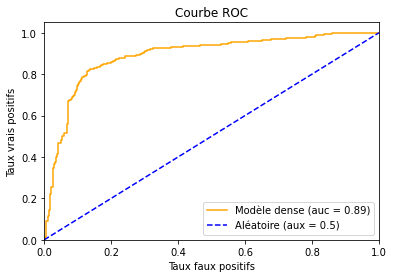

In [172]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, seuils = roc_curve(y_true, error_slider, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'orange', label = 'Modèle dense (auc = %0.2f)' % roc_auc)
plt.title('Courbe ROC')
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.xlim(0,1)
plt.ylim(0,1.05)

plt.plot(fpr, fpr, 'b--', label = 'Aléatoire (aux = 0.5)')

plt.legend(loc = 'lower right')
plt.show();

In [173]:
auc = roc_auc_score(y_true, y_pred)
p_auc = roc_auc_score(y_true, y_pred, max_fpr=0.1)

print("AUC : {}".format(auc))
print("pAUC : {}".format(p_auc))

AUC : 0.8295786516853934
pAUC : 0.5806802084909164


## Affinons notre analyse selon le Machine_ID

In [156]:
#slider_train.Machine_ID.value_counts()
slider_train.Machine_ID.unique()

array([0, 6, 2, 4])

### Premier Machine_ID : 0

In [181]:
error_slider_train_0 = error_slider_train[slider_train.Machine_ID == 0]

print('Moyenne des erreurs :', np.mean(error_slider_train_0))
print('Ecart-type des erreurs :', np.std(error_slider_train_0))

seuil = 11.4 # valeur à déterminer selon les erreurs 

Moyenne des erreurs : 10.06757308332017
Ecart-type des erreurs : 0.8538450127004871


In [182]:
y_true_0 = y_true[slider_test.Machine_ID == 0]
y_pred_0 = np.where(error_slider_test[slider_test.Machine_ID == 0][:] > seuil, 1, 0)

print(classification_report(y_true_0, y_pred_0))
pd.crosstab(y_true_0, y_pred_0, rownames=['Classe réelle'], colnames=['Classe prédite'])

              precision    recall  f1-score   support

           0       0.98      0.80      0.88       100
           1       0.95      0.99      0.97       356

    accuracy                           0.95       456
   macro avg       0.96      0.90      0.92       456
weighted avg       0.95      0.95      0.95       456



Classe prédite,0,1
Classe réelle,,
0,80,20
1,2,354


In [183]:
auc = roc_auc_score(y_true_0, y_pred_0)
p_auc = roc_auc_score(y_true_0, y_pred_0, max_fpr=0.1)

print("AUC : {}".format(auc))
print("pAUC : {}".format(p_auc))

AUC : 0.897191011235955
pAUC : 0.6045239503252513


### Deuxième Machine_ID : 2 

In [197]:
error_slider_train_2 = error_slider_train[slider_train.Machine_ID == 2]

print('Moyenne des erreurs :', np.mean(error_slider_train_2))
print('Ecart-type des erreurs :', np.std(error_slider_train_2))

seuil = 10.8 # valeur à déterminer selon les erreurs 

Moyenne des erreurs : 10.172492965291347
Ecart-type des erreurs : 0.9994760888384666


In [198]:
y_true_2 = y_true[slider_test.Machine_ID == 2]
y_pred_2 = np.where(error_slider_test[slider_test.Machine_ID == 2][:] > seuil, 1, 0)

print(classification_report(y_true_2, y_pred_2))
pd.crosstab(y_true_2, y_pred_2, rownames=['Classe réelle'], colnames=['Classe prédite'])

              precision    recall  f1-score   support

           0       0.50      0.66      0.57       100
           1       0.86      0.76      0.80       267

    accuracy                           0.73       367
   macro avg       0.68      0.71      0.69       367
weighted avg       0.76      0.73      0.74       367



Classe prédite,0,1
Classe réelle,,
0,66,34
1,65,202


In [199]:
auc = roc_auc_score(y_true_2, y_pred_2)
p_auc = roc_auc_score(y_true_2, y_pred_2, max_fpr=0.1)

print("AUC : {}".format(auc))
print("pAUC : {}".format(p_auc))

AUC : 0.7082771535580523
pAUC : 0.532241045442423


### Troisième Machine_ID : 4

In [209]:
error_slider_train_4 = error_slider_train[slider_train.Machine_ID == 4]

print('Moyenne des erreurs :', np.mean(error_slider_train_4))
print('Ecart-type des erreurs :', np.std(error_slider_train_4))

seuil = 12 # valeur à déterminer selon les erreurs 

Moyenne des erreurs : 10.585692787462927
Ecart-type des erreurs : 0.9945730578638943


In [210]:
y_true_4 = y_true[slider_test.Machine_ID == 4]
y_pred_4 = np.where(error_slider_test[slider_test.Machine_ID == 4][:] > seuil, 1, 0)

print(classification_report(y_true_4, y_pred_4))
pd.crosstab(y_true_4, y_pred_4, rownames=['Classe réelle'], colnames=['Classe prédite'])

              precision    recall  f1-score   support

           0       0.98      0.87      0.92       100
           1       0.93      0.99      0.96       178

    accuracy                           0.95       278
   macro avg       0.95      0.93      0.94       278
weighted avg       0.95      0.95      0.95       278



Classe prédite,0,1
Classe réelle,,
0,87,13
1,2,176


In [211]:
auc = roc_auc_score(y_true_4, y_pred_4)
p_auc = roc_auc_score(y_true_4, y_pred_4, max_fpr=0.1)

print("AUC : {}".format(auc))
print("pAUC : {}".format(p_auc))

AUC : 0.92938202247191
pAUC : 0.6738388754947005


### Quatrième Machine_ID : 6

In [229]:
error_slider_train_6 = error_slider_train[slider_train.Machine_ID == 6]

print('Moyenne des erreurs :', np.mean(error_slider_train_6))
print('Ecart-type des erreurs :', np.std(error_slider_train_6))

seuil = 10.8 # valeur à déterminer selon les erreurs 

Moyenne des erreurs : 10.580069491440288
Ecart-type des erreurs : 1.3055483512960364


In [230]:
y_true_6 = y_true[slider_test.Machine_ID == 6]
y_pred_6 = np.where(error_slider_test[slider_test.Machine_ID == 6][:] > seuil, 1, 0)

print(classification_report(y_true_6, y_pred_6))
pd.crosstab(y_true_6, y_pred_6, rownames=['Classe réelle'], colnames=['Classe prédite'])

              precision    recall  f1-score   support

           0       0.90      0.60      0.72       100
           1       0.67      0.92      0.78        89

    accuracy                           0.75       189
   macro avg       0.78      0.76      0.75       189
weighted avg       0.79      0.75      0.75       189



Classe prédite,0,1
Classe réelle,,
0,60,40
1,7,82


In [231]:
auc = roc_auc_score(y_true_6, y_pred_6)
p_auc = roc_auc_score(y_true_6, y_pred_6, max_fpr=0.1)

print("AUC : {}".format(auc))
print("pAUC : {}".format(p_auc))

AUC : 0.7606741573033708
pAUC : 0.5342992312241277
